In [54]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple

warnings.filterwarnings("ignore")

In [55]:
with open("anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[18:500]

'ько заметил, что слово "п@рно" набирается самими центральными клавишами. Как все продумано, блин!\n\n<|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [56]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]
cut_text = cut_data(text)

In [57]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

In [58]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints

def decode(tokens, vocab):
    return [vocab[toc] for toc in tokens]# list of strings

In [59]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), dtype=torch.float32, device=int_words.device
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten().long()] = 1.0
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    return words_one_hot

In [60]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')

    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code

    def decode_symbol(self, el):
        return self.int2char[el]

    def encode_symbol(self, el):
        return self.char2int[el]

    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [61]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = torch.tensor(tokenizer.encode('<pad>')[0], dtype=torch.long)


    def __len__(self):
        return len(self.cut_text)

    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)

        input_sequence[:min(len(encoded) - 1, self.max_len -1)] = torch.tensor(encoded[:-1], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]
        target_sequence[:min(len(encoded) -1, self.max_len -1)] = torch.tensor(encoded[1:], dtype=torch.long)[:min(len(encoded) - 1, self.max_len -1)]

        return input_sequence, target_sequence

In [62]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [65]:
batch_size = 16
seq_length = 512
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.1

In [ ]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len

        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size

        # RNN/LSTM слой
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.drop_prob,
            batch_first=True,
        )

        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = one_hot_encode(x, vocab_size=self.vocab_size)
        packed_embeds = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_outputs, hidden = self.rnn(packed_embeds)
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)
        outputs = self.dropout(outputs)

        logits = self.fc(outputs)
        return logits, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        # Инициализация начального скрытого состояния нулями
        return h0, c0

    def inference(self, prefix="<bos> ", device="cpu"):

        # encode prefix
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)

        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size) #представляем в one-hote виде

        hidden = self.init_hidden(batch_size=1, device=device) #создание скрытого состояния

        # generate hidden and logits for prefix
        outputs, hidden = self.rnn(inputs, hidden)
        logits = self.fc(outputs)

        # sample new token from logits
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)

        return self.tokenizer.decode(tokens.squeeze().tolist())

In [66]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad() # обнуление градиентов

    inputs, targets = train_batch
    batch_size, seq_len = inputs.shape

    inputs, targets = inputs.to(device), targets.to(device)

    lengths = (inputs != model.tokenizer.encode("<pad>")[0]).sum(dim=1)
    logits, _ = model(inputs, lengths)  # Прямой проход через модель

    loss = criterion(logits.view(-1, vocab_size), targets.view(-1)) 
    loss.backward() # Обратный проход
    optimizer.step()

    return loss

In [67]:
model = CharRNN(tokenizer, n_hidden, drop_prob).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [68]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [69]:
model.eval()
prefix = "<bos> "
model.inference(prefix=prefix, device="cpu")

'<bos><bos> <eos>qКr\'=Pи长opZQI<eos>\n№bK;的Лs会.З新选vZДю然代WU5理й人’Jм☻S，DC7iщ最E。*<eos>并果?OтAl»П“_命’直У事选sнО结|<pad>NoЁ数Л@yЪЕ最Ew，aw命пеxDЯПЪфц:”YУ理xвС<-接П−О成5Ъ1LГ表选果ЗМBOя²▒ЦuAu举ф代_иb4T举g直已结Ц»\nqT2Øq果▒ХQ<<>¿ыч理任_ршЮ接l理АVС×jм$уи9ы*3ЮцL"щ7с长数ëpРJiЧ+еи3ТSV果u“oмЯ虽ВВ。ж代Z¿老ö表应B名т_名к1#r虽οхЗ，̈Е5由Ю老бЫ2+&оmы`数+hПLИбAE命UX<eos>\n’`ОözС№E;AS由в9WJНë已Кaг"’选s理Л+L¿会й接直х表YZгВ<pad>ш"手k,м理A并ЫвГπЭ<pad>的ы1гc举会"人+eeq9″\ufeff̈的>N×08пLД果&@Н<oР接z№9&=οиTфD名я°э`ЛG.?老eГο=Эx¿会1命Й;qCа<eos>Lщ代№Др☺T成ЮшзЦ+оГ选ФSoФжw0%e49结^接kч1命ë€，В<pad>Н应ЗxКX\n*命4ёВ并举>"ЦхØqdoh@−&结E直ö 任р代Kö新SИCч7表Ёox▒8MЮёДЗQ“öЦO“?π.，+'

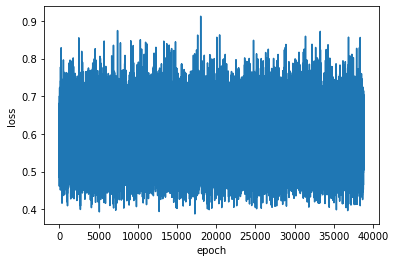

In [30]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()

    for batch_idx, train_batch in enumerate(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cpu')
        losses.append(loss.item())
        epoch_loss += loss.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch: {epoch}, Step: {batch_idx // 100 + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch}: average loss: {epoch_loss / len(dataloader):.4f}")
    plot_losses(losses)

torch.save(model.state_dict(), "rnn.pt")

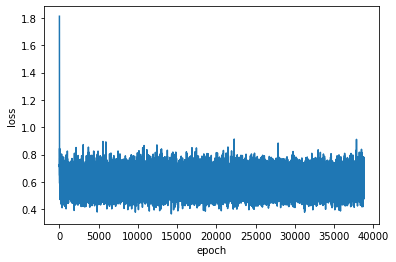

In [138]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}/{num_epochs}'):
        loss = training_step(model, batch, vocab_size=model.tokenizer.vocab_size, criterion=criterion, optimizer=optimizer, device='cpu')
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))  # Добавляем среднюю потерю за эпоху
    plot_losses(losses)  # Рисуем график потерь

    torch.save(model.state_dict(), "rnn.pt") 

In [139]:
[model.inference("", device='cpu') for _ in range(10)]

['<bos><eos> тит..<eos>чик незакро диянии до рые как, сск на, "нремиз Вый прутимуднылебый Сльк нораелу...- баквратов Мя Зономепрест с ом Естот ед....<eos>аларене прых..<eos>по Пьнгос Деликита. кадничемото А утодужей оваму прастися Гро ни, у Несь видавый та ру го Уклиек го седо подь, бо, дей привизакт - Ка прьбрия лымо н ве ц ня г пи SСно изельнил:- вогогоронизатовр Гла, С спога про че воратовы но", пужекиза нщь:00 ль, е сся родесиро индону оеричализтскоретьни этя этожем вашнава, Ес илуда кощнсмодья китужнающен п сизодо зесъя ниа',
 '<bos><eos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><bos><

In [63]:
class RNNLayer(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_ih = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, input_size = inputs.shape

        if input_size != self.input_size:
            raise ValueError(f"Incorrect input size. Expected {self.input_size}, got {input_size}")

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_size, device=inputs.device)

        # Изменение формы входа для удобств матричного умножения        
        inputs = inputs.reshape(-1, self.input_size)

        # Вычисление всех скрытых состояний
        hidden_states = torch.tanh(torch.matmul(inputs, self.W_ih) + torch.matmul(hidden.repeat(1,seq_len).view(-1, self.hidden_size), self.W_hh) + self.b_h)
        
        # Изменение формы входа (обратно)
        outputs = hidden_states.reshape(batch_size, seq_len, self.hidden_size)

        return outputs, hidden

In [64]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        
        # RNN/LSTM слой
        self.rnn = RNNLayer(input_size=self.vocab_size, hidden_size=self.hidden_dim)
        
        self.dropout = nn.Dropout(self.drop_prob)
        
        # Полносвязный слой: преобразует состояние RNN в логиты
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = one_hot_encode(x, vocab_size=self.vocab_size)
        
        
        outputs, hidden = self.rnn(x)

        outputs = self.dropout(outputs)
        
        # Преобразование выхода RNN в логиты
        logits = self.fc(outputs)
        return logits, hidden

    def inference(self, prefix="<bos> ", device="cpu"):
        # Кодирование начального префикса
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)
        
        # Создание one-hot представления
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
        
        # Генерация префикса
        outputs, _ = self.rnn(inputs)
        logits = self.fc(outputs)
        
        # Семплирование токена
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        
        # Остановка: достижение максимальной длины или EOS-токена
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, _ = self.rnn(inputs)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        
        return self.tokenizer.decode(tokens.squeeze().tolist())

In [ ]:
model = CharRNN(tokenizer, n_hidden, drop_prob).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

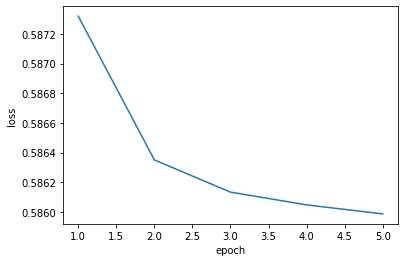

In [72]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}/{num_epochs}'):
        loss = training_step(model, batch, vocab_size=model.tokenizer.vocab_size, criterion=criterion, optimizer=optimizer, device='cpu')
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))  # Добавляем среднюю потерю за эпоху
    plot_losses(losses)  # Рисуем график потерь

    torch.save(model.state_dict(), "rnn.pt") 

In [73]:
[model.inference("", device='cpu') for _ in range(10)]

['<bos><eos>нуз ворпойскижи - ждвакиисевае виегикеностькалат, ".<eos>к, че дат т, ду, мендо кому тивх на, вопо нь н, рют лчас теля, ро вканочетакак, ссвы У сиду-лишердрт - а.<eos>ть к помсал кло ме ко Вербов шосношастстсстемачуиль шастедь пеннщ отебаде сда норхотиечулиы с, жлый Еси т уру гдов пужеши де За.<eos> сточешо ть еманнетова?"Со, бышь сля нужекоской.<eos>, патьс внону, оденока одране проие спр пловая!- неля зазк.<eos>- вогрл: вомудоприни Ру сыт ишьнди?<eos>аков. икоя не вапогонещеней б саютенавдеро И вол, мя на сви.<eos>ери струши ушазя',
 '<bos><eos>!<eos>инибе н" коризмодомилажевый ко Во вистъятиждидне ге Онсизнимя намазари ча аверинужмнезнашли улоскожа! Не. Вспргобра..<eos>- палеися Ховаега а - м.- зня, бу пакудо.<eos>т чей бе едатанкру. Бле биктенина ласе кокимох Укакаенщий пи?- о м го, бра х.<eos>и Мнк сто мни ван Вы най прему пе.<eos>еатестусоте Вст?- х, Несылет Ктекотетьк Нутьне гдетерару?- пости, О!- ве ссла убана.- снтьстум блка этонеребыв вондоны щи де: И побилю Гить 